# A Tutorial on Noisy Gaussian Process Regression


### By Jerry Jeyachandra [(github)](https://www.github.com/jerdra)
##### Sourced from Rasmussen & Williams (2006)

# Problem Set-up
***

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

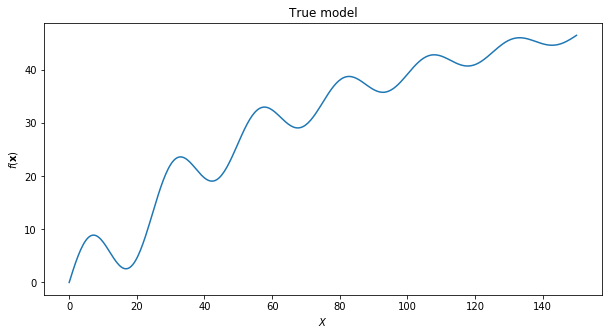

In [293]:
#Generate the true model
x = np.linspace(0,150,400)
y = (8*np.exp(-0.0125*x))*np.sin(x*0.25) + 0.055*x + 50*np.exp(-10/(1+0.25*x))

## Visualize
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(x,y)
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('True model')
plt.show()

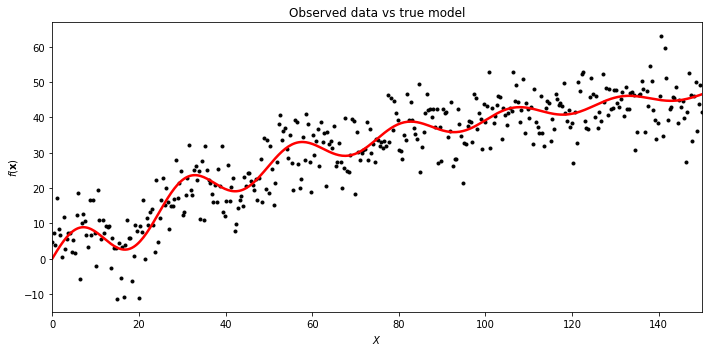

In [297]:
#Generate noisy observations
y_obs = y + np.random.normal(loc=0,scale=6.25,size=y.shape)

#Plot noisy observations
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(x,y_obs,'k.')
ax.plot(x,y,'r', lw=2.5)
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('Observed data vs true model')
ax.set_xlim(left=0,right=150)
plt.tight_layout()
plt.show()

Our goal is to estimate the true underlying model $f(\mathbf{x})$ given noisy observations in the form of $X$. To do this we will use **Gaussian Process Regression** $\mathcal{GP}$, which is a Bayesian technique in order to non-parameterically model a stochastic process probabilistically over **function space**. That is, we have distributions over functions rather than single values.

The $\mathcal{GP}$ can be fully specified with two components, the **mean function** and the **covariance function**:

$$m(\mathbf{x}) = \mathbb{E}\left[ f(\mathbf{x}) \right]$$
$$k(\mathbf{x}_i,\mathbf{x}_j) = \mathbb{E}\left[ (f(\mathbf{x}_i) - m(\mathbf{x}) ) (f(\mathbf{x}_j) - m(\mathbf{x}) ) \right]$$

We represent the distribution that we believe that our data is drawn from as follows:

$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}_i,\mathbf{x}_j))$$


As $\mathcal{GP}$ is a Bayesian model we need to specify a prior that indicates a belief about the structure of our data.

## Building our Prior
***

### Mean Function
Let's start with a rather uninformed prior **mean function**, of course if I suspected that the data might be some periodic function, I could pre-fit with a least-squares model as a starting point:

$$m(x) = \mathbf{0} $$

### Covariance Function
I used this example to demonstrate that the **covariance function** of $\mathcal{GP}$ is extremely flexible and allows us to model a variety of phenomena as long as we know something about the intrinsic structure of the data.

The covariance function is where most of the art/domain knowledge behind $\mathcal{GP}$ begins. The covariance function is a *statement about what you believe the function you're modelling behaves like*. Suppose I know three things about the data I'm modelling:

1. **Growth** - the data seems to express growth as the input parameter $X$ grows
2. **Seasonality** - the data I'm modelling has some periodicity associated with it
3. **Smoothness** - I expect some continuity in my data, there doesn't seem to be an underlying erraticness


I can build these three *beliefs* into my model using the **covariance function**. To do this we're going to model our data with a combination of two basis covariance functions: 

1. **Squared Distance Function**
2. **Sinusoidal Distance Model** 
3. **Exponential Function**

***

#### Squared Exponential Distance Function

$$d_1 (\mathbf{x}_i,\mathbf{x}_j) =  -\frac{1}{2\sigma^2} \| \mathbf{x}_i - \mathbf{x}_j \| $$

Mathematically this function expresses the following belief:

$$\lim_{\mathbf{x}_i \to \mathbf{x}_j} \|f(\mathbf{x}_i) - f(\mathbf{x}_j) \| \to 0$$
Simply put, we believe that as $\mathbf{x}_i$ gets close to $\mathbf{x}_j$, so too should $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$. 

####  Sinusoidal Function

$$d_2 (\mathbf{x}_i, \mathbf{x}_j) =  -2\sin \frac{\pi}{T} (\mathbf{x}_i - \mathbf{x}_j)$$

This basis function expresses the belief that our data should act sinusoidally over our input parameter space $X$. 

#### Exponential Function

$$\exp[ s(\mathbf{x}_i, \mathbf{x}_j ) ]$$

This function encodes the belief that the underlying function we're modelling exhibits a property of smoothness. Exponential functions have the neat property of being *infinitely differentiable* which manifests as functions being very smooth.

***

#### The combined covariance function

Our final covariance function is the following:

$$k(\mathbf{x}_i, \mathbf{x}_j) = \gamma 
\exp\left( \alpha * d_1(\mathbf{x}_i,\mathbf{x}_j)  \right)
\exp\left( \beta  * d_2(\mathbf{x}_i,\mathbf{x}_j)  \right)
$$

Substituting our distance functions:

$$k(\mathbf{x}_i, \mathbf{x}_j) = \gamma \exp \left[ 
-\alpha\frac{1}{2} \| \mathbf{x}_i - \mathbf{x}_j \| - 
2\beta \sin\left( \frac{\pi}{T} [\mathbf{x}_i - \mathbf{x}_j] \right) 
\right]$$

Where $\gamma,\alpha,\beta, T$ are hyper-parameters for our model. Typically you would optimize these parameters using either of the following methods:

1. Log-likelihood maximization (gradient ascent)
2. Bayesian Optimization
3. Grid-Search
4. Random Sampling

 
For the purposes of the tutorial we'll remove the process of finding $T$. I'll make the argument that we can approximate T by looking at the data's periodicity to simplify the hyper-parameter tuning problem. Thus the goal is two-fold:

1. Estimate the $\mathcal{GP}$ model that best approximates our data
2. Find the hyperparameters $\alpha, \beta, \gamma$ that allow for $(1)$ to be fulfilled

***
# Gaussian Process Regression
In this section we perform the following:
1. Log-likelihood maximization of covariance function hyper-parameters
2. $\mathcal{GP}$ modelling of our synthetic dataset
***